In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import random

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

## Adding random seed

In [32]:
# Set random seed for reproducibility
torch.manual_seed(17)
np.random.seed(17)
random.seed(17)

# 1D Gaussian process in Python
reference: https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH02/01%20-%20Gaussian%20processes.ipynb

In [ ]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [33]:
train_x = torch.rand(size = (3,1)) * 6 -1
train_y = forrester_1d(train_x)

In [37]:
train_x

tensor([[1.6054],
        [2.2107],
        [3.9813]])

In [22]:
train_x

tensor([[1.6054],
        [2.2107],
        [3.9813]])

## Setting random seed 17 so that we can check if the output match with the original or not

## Copying the data generation from the original

In [15]:
# Data Generation
nv = 20
xv = np.linspace(-5., 5., nv)
yv = np.linspace(-5., 5., nv)
x, y = np.meshgrid(xv, yv)
#z = (x - 3.)**2 + 2.*x*y + (2.*y + 3.)**2 - 3.

In [17]:
def function(x,y):
    z = (x - 3.)**2 + 2.*x*y + (2.*y + 3.)**2 - 3.
    return z

In [18]:
z = function(x,y)

## Adding Gaussian Noise 

In [19]:
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

scikit-learn expects each input and output as column vectors, so we must reshape the grid:

In [10]:
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

In [ ]:
# --- Define the GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [ ]:
# Data Splitting and Normalization
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(Y_train_normalized).float().squeeze()
X_tensor = torch.from_numpy(X).float()

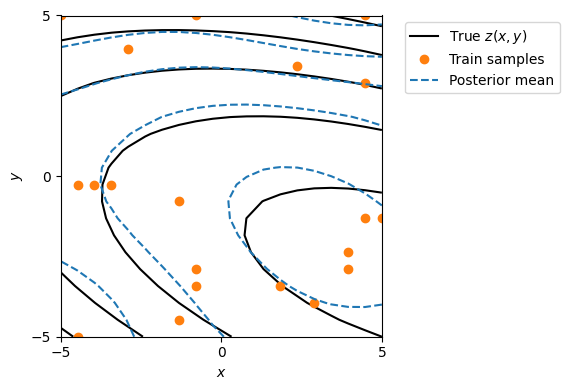

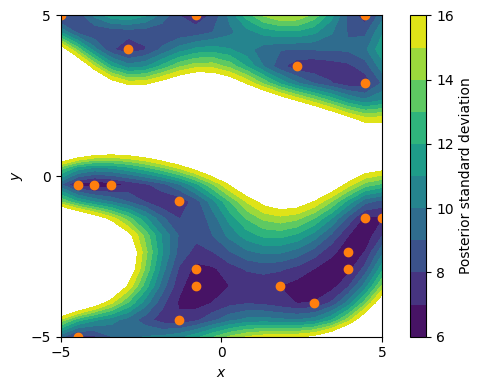

In [ ]:
# Initialize likelihood and model with constraints
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(train_x, train_y, likelihood)

# --- Set Hyperparameters with Constraints ---
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])
model.covar_module.base_kernel.register_prior(
    "lengthscale_prior",
    gpytorch.priors.NormalPrior(1.0, 1.0),
    "lengthscale"
)
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)

model.covar_module.outputscale = 1.0
model.covar_module.register_prior(
    "outputscale_prior",
    gpytorch.priors.NormalPrior(1.0, 1.0),
    "outputscale"
)
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)

likelihood.noise = 0.1

# --- Train the Model ---
model.train()
likelihood.train()

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss

for i in range(50):
    optimizer.step(closure)

# --- Make Predictions ---
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_tensor))
    prediction_mean = observed_pred.mean.numpy()
    prediction_std = observed_pred.stddev.numpy()

zfit_original = prediction_mean * y_std + y_mean
zstd_original = prediction_std * y_std

zfit = zfit_original.reshape(x.shape)
zstd = zstd_original.reshape(x.shape)

# --- Plot Posterior Mean ---
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_aspect('equal')
ax.set_xticks((-5, 0, 5))
ax.set_yticks((-5, 0, 5))
ax.grid(False)

lev = np.linspace(0., 250., 6)
ax.contour(x, y, z, lev, colors='k')  # Truth
ax.plot(*X_train.T, 'o', color="C1")  # Training samples
ax.contour(x, y, zfit, lev, colors='C0', linestyles='dashed')  # Posterior mean

truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line], bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig('gpr_posterior_mean.svg')

# --- Plot Posterior Standard Deviation ---
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_aspect('equal')
ax.set_xticks((-5, 0, 5))
ax.set_yticks((-5, 0, 5))
ax.grid(False)

ax.plot(*X_train.T, 'o', color="C1")  # Training samples
lev = np.linspace(6., 16., 11)
hc = ax.contourf(x, y, zstd, lev)  # Posterior std

hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')

plt.tight_layout()
plt.savefig('gpr_posterior_std.svg')